# Test code for computing complexity in range estimates instead of fixed values

In [1]:
from utils import helpers, constants
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

data_dictionary = helpers.load_data_dictionary(constants.DATA_DICTIONARY_FILE_PATH)
# filter data_dictionary
keep_keys = {"ACCRE", "SEPSIS", "BPIC12"}
data_dictionary = {k: v for k, v in data_dictionary.items() if k in keep_keys}

configurations = ["processGraphsPDefaultWDefault"]

dd_results_df = helpers.get_dataframe_from_drift_detection_results(data_dictionary.keys(), configurations)
dd_results_df

,dataset,configuration,change_point,change_moment
0,BPIC12,processGraphsPDefaultWDefault,278,2011-10-04 20:52:56.033000+00:00
1,BPIC12,processGraphsPDefaultWDefault,647,2011-10-09 12:24:01.935000+00:00
2,BPIC12,processGraphsPDefaultWDefault,856,2011-10-12 08:15:41.609000+00:00
3,BPIC12,processGraphsPDefaultWDefault,1464,2011-10-19 14:14:07.705000+00:00
4,BPIC12,processGraphsPDefaultWDefault,1814,2011-10-24 10:22:03.397000+00:00
5,BPIC12,processGraphsPDefaultWDefault,1964,2011-10-25 20:46:42.323000+00:00
6,BPIC12,processGraphsPDefaultWDefault,2624,2011-11-03 11:15:07.632000+00:00
7,BPIC12,processGraphsPDefaultWDefault,2885,2011-11-07 09:00:23.384000+00:00
8,BPIC12,processGraphsPDefaultWDefault,3235,2011-11-10 12:06:19.906000+00:00
9,BPIC12,processGraphsPDefaultWDefault,3416,2011-11-10 22:04:02.349000+00:00


In [ ]:
from __future__ import annotations
from typing import List, Dict, Any, Tuple, Optional, Callable
import numpy as np
import pandas as pd

# ============================================================
# Split the log into consecutive chunks by change points
# ============================================================
def split_log_by_change_points(pm4py_log, change_points: List[int]):
    """
    change_points are cumulative end indices (Python slicing end positions).
    Example: [100, 250] -> chunks [:100], [100:250], [250:len]
    Returns: (chunks, bounds) where bounds = [0, cp1, cp2, ..., n]
    """
    n = len(pm4py_log)
    cps = sorted(set(int(cp) for cp in change_points if 0 < cp < n))
    bounds = [0] + cps + [n]
    chunks = []
    for i in range(len(bounds) - 1):
        start, end = bounds[i], bounds[i + 1]
        if end > start:
            chunks.append(pm4py_log[start:end])
    return chunks, bounds

# ============================================================
# Richness estimators (q=0)
#   - Chao1 (abundance/individual-based)
#   - Chao2 (incidence/sample-based)
# ============================================================
def richness_abundance_chao1(counts: Dict[Any, int], n: int) -> Dict[str, float]:
    """
    counts: species -> abundance count (sum(counts)=n)
    n: total number of individuals (for variants, n == #traces in chunk)
    """
    S_obs = len(counts)
    f1 = sum(1 for c in counts.values() if c == 1)
    f2 = sum(1 for c in counts.values() if c == 2)

    # Chao1 lower-bound estimator (bias-corrected fallback if f2==0)
    if f2 > 0:
        S_hat = S_obs + (f1 * f1) / (2.0 * f2)
    else:
        S_hat = S_obs + (f1 * (f1 - 1)) / 2.0

    # q=0 completeness
    C0 = S_obs / S_hat if S_hat > 0 else float("nan")

    # Abundance sample coverage (Chao–Lee):
    # C1 = 1 - (f1/n) * ((n-1)f1 / ((n-1)f1 + 2f2))
    if n > 0:
        denom = (n - 1) * f1 + 2 * f2
        adj = ((n - 1) * f1 / denom) if denom > 0 else 1.0
        C1 = 1.0 - (f1 / n) * adj
    else:
        C1 = float("nan")

    return {
        "Estimator": "Chao1",
        "S_obs": float(S_obs),
        "f1_or_Q1": float(f1),
        "f2_or_Q2": float(f2),
        "S_hat_inf": float(S_hat),
        "C0": float(C0),
        "C1": float(C1),
    }

def richness_incidence_chao2(counts: Dict[Any, int], T: int, U: int) -> Dict[str, float]:
    """
    counts: species -> number of sampling units (traces) where it occurs (incidence)
    T: number of sampling units (traces in the chunk)
    U: total incidence (sum(counts.values()))
    """
    S_obs = len(counts)

    # frequency-of-incidence across species
    freq_counts: Dict[int, int] = {}
    for y in counts.values():
        freq_counts[y] = freq_counts.get(y, 0) + 1
    Q1 = freq_counts.get(1, 0)
    Q2 = freq_counts.get(2, 0)

    # Chao2 lower-bound estimator (bias-corrected fallback if Q2==0)
    if Q2 > 0:
        S_hat = S_obs + ((T - 1) / T) * (Q1 * Q1) / (2.0 * Q2)
    else:
        S_hat = S_obs + (Q1 * (Q1 - 1)) / 2.0

    C0 = S_obs / S_hat if S_hat > 0 else float("nan")

    # Incidence sample coverage (Chao–Jost):
    # C1 = 1 - (Q1 / U) * ((T-1) * Q1 / ((T-1) * Q1 + 2 * Q2))
    if U > 0:
        denom = (T - 1) * Q1 + 2.0 * Q2
        adj = ((T - 1) * Q1 / denom) if denom > 0 else 1.0
        C1 = 1.0 - (Q1 / U) * adj
    else:
        C1 = float("nan")

    return {
        "Estimator": "Chao2",
        "S_obs": float(S_obs),
        "f1_or_Q1": float(Q1),
        "f2_or_Q2": float(Q2),
        "S_hat_inf": float(S_hat),
        "C0": float(C0),
        "C1": float(C1),
    }

# --- helpers for population bootstrap math on arrays ---
def _chao1_from_counts_array(xs: np.ndarray) -> float:
    S_obs = int((xs > 0).sum())
    f1 = int((xs == 1).sum())
    f2 = int((xs == 2).sum())
    if f2 > 0:
        return S_obs + (f1 * f1) / (2.0 * f2)
    else:
        return S_obs + (f1 * (f1 - 1)) / 2.0

def _chao2_from_incidence_array(y: np.ndarray, T: int) -> float:
    S_obs = int((y > 0).sum())
    Q1 = int((y == 1).sum())
    Q2 = int((y == 2).sum())
    if Q2 > 0:
        return S_obs + ((T - 1) / T) * (Q1 * Q1) / (2.0 * Q2)
    else:
        return S_obs + (Q1 * (Q1 - 1)) / 2.0

# ============================================================
# Bootstrap CI for q=0 richness using a species_counter_fn
#   species_counter_fn(chunk) -> (counts: dict, meta: dict)
#   For model="abundance": meta should include n (falls back to sum(counts))
#   For model="incidence": meta should include T (falls back to len(chunk)),
#                          U (falls back to sum(counts))
# Modes:
#   - "empirical": resample traces (units) with replacement, recompute richness
#   - "population": smoothed bootstrap via estimated population with unseen mass
# ============================================================
def bootstrap_richness_ci_with_counter(
    chunk,
    species_counter_fn: Callable[[list], Tuple[Dict[Any, int], Dict[str, int]]],
    model: str = "abundance",              # "abundance" (Chao1) or "incidence" (Chao2)
    B: int = 1000,
    alpha: float = 0.05,
    seed: Optional[int] = 42,
    bootstrap_mode: str = "population",    # "empirical" or "population"
) -> Tuple[float, float, float]:
    """
    Returns (ci_low, ci_high, boot_mean) for asymptotic richness ^0D(infinity).
    """
    traces = list(chunk)
    m = len(traces)
    if m == 0:
        return (float("nan"), float("nan"), float("nan"))

    rng = np.random.default_rng(seed)
    estimates = np.empty(B, dtype=float)

    # Baseline counts/meta from full chunk (used by population mode)
    counts_full, meta_full = species_counter_fn(traces)

    if model == "abundance":
        # observed abundance counts & totals
        x = np.array(list(counts_full.values()), dtype=int)
        n = int(meta_full.get("n", int(x.sum())))
        est_full = richness_abundance_chao1(counts_full, n)
        S_obs = int(est_full["S_obs"])
        S_hat = float(est_full["S_hat_inf"])
        C1 = float(est_full["C1"])
        u = max(0.0, 1.0 - C1)                       # unseen probability mass
        D0_hat = max(0, int(round(S_hat - S_obs)))   # estimated #unseen species

        if bootstrap_mode == "empirical":
            # resample traces; recompute counts & richness
            for b in range(B):
                idx = rng.integers(0, m, size=m)
                resample = [traces[i] for i in idx]
                counts, meta = species_counter_fn(resample)
                n_b = int(meta.get("n", sum(counts.values())))
                estimates[b] = richness_abundance_chao1(counts, n_b)["S_hat_inf"]
        else:
            # population/smoothed bootstrap for abundance
            p_seen = x / x.sum() if x.sum() > 0 else np.array([])
            p_seen = (1.0 - u) * p_seen
            if D0_hat > 0 and u > 0:
                p_unseen = np.full(D0_hat, u / D0_hat, dtype=float) # distribute unseen probability mass over estimated #unseen species
                p = np.concatenate([p_seen, p_unseen])
            else:
                p = p_seen
            if p.sum() > 0:
                p = p / p.sum()

            for b in range(B):
                xs = rng.multinomial(n, p)  # counts across seen+unseen categories
                estimates[b] = _chao1_from_counts_array(xs)

    else:  # model == "incidence"
        y = np.array(list(counts_full.values()), dtype=int)
        T = int(meta_full.get("T", len(traces)))
        U = int(meta_full.get("U", int(y.sum())))
        est_full = richness_incidence_chao2(counts_full, T, U)
        S_obs = int(est_full["S_obs"])
        S_hat = float(est_full["S_hat_inf"])
        C1 = float(est_full["C1"])
        u = max(0.0, 1.0 - C1)
        D0_hat = max(0, int(round(S_hat - S_obs)))

        if bootstrap_mode == "empirical":
            for b in range(B):
                idx = rng.integers(0, m, size=m)
                resample = [traces[i] for i in idx]
                counts, meta = species_counter_fn(resample)
                T_b = int(meta.get("T", len(resample)))
                U_b = int(meta.get("U", sum(counts.values())))
                estimates[b] = richness_incidence_chao2(counts, T_b, U_b)["S_hat_inf"]
        else:
            # population/smoothed bootstrap for incidence
            pi_seen = (y / T) if T > 0 else np.array([])
            pi_seen = (1.0 - u) * pi_seen
            if D0_hat > 0 and u > 0:
                pi_unseen = np.full(D0_hat, u / D0_hat, dtype=float)
                pi = np.concatenate([pi_seen, pi_unseen])
            else:
                pi = pi_seen
            pi = np.clip(pi, 0.0, 1.0)

            for b in range(B):
                y_star = rng.binomial(T, pi)  # #units occupied per species category
                estimates[b] = _chao2_from_incidence_array(y_star, T)

    lo = float(np.percentile(estimates, 100 * (alpha / 2.0)))
    hi = float(np.percentile(estimates, 100 * (1 - alpha / 2.0)))
    mean = float(np.mean(estimates))
    return lo, hi, mean

# ============================================================
# Build the per-window table (generic, species-agnostic)
# ============================================================
def compute_richness_table_with_counter(
    pm4py_log,
    change_points: List[int],
    species_counter_fn: Callable[[list], Tuple[Dict[Any, int], Dict[str, int]]],
    model: str = "abundance",                # "abundance" (Chao1) or "incidence" (Chao2)
    B: int = 1000,
    alpha: float = 0.05,
    seed: Optional[int] = 42,
    bootstrap_mode: str = "population",      # "empirical" or "population"
    enforce_bounds: bool = True,             # clip CI_low >= S_obs, ensure S_hat in CI
    include_meta: bool = True,               # include size meta columns
) -> pd.DataFrame:
    """
    Returns a tidy per-window table with:
      S_obs, f1_or_Q1, f2_or_Q2, S_hat_inf, CI_low/CI_high (bootstrap),
      Predicted_actual_boot_mean, C0, C1, and window bounds.
    """
    assert model in {"abundance", "incidence"}
    assert bootstrap_mode in {"empirical", "population"}

    chunks, bounds = split_log_by_change_points(pm4py_log, change_points)
    rows = []

    for i, chunk in enumerate(chunks):
        window_id = f"W{i+1}"
        window_start = bounds[i]
        window_end = bounds[i + 1] - 1  # inclusive

        counts, meta = species_counter_fn(chunk)

        if model == "abundance":
            n = meta.get("n", sum(counts.values()))
            est = richness_abundance_chao1(counts, n)
        else:
            T = meta.get("T", len(chunk))
            U = meta.get("U", sum(counts.values()))
            est = richness_incidence_chao2(counts, T, U)

        ci_low, ci_high, boot_mean = bootstrap_richness_ci_with_counter(
            chunk,
            species_counter_fn,
            model=model,
            B=B,
            alpha=alpha,
            seed=None if seed is None else seed + i,
            bootstrap_mode=bootstrap_mode,
        )

        S_obs = int(est["S_obs"])
        S_hat = float(est["S_hat_inf"])

        if enforce_bounds:
            # never below observed richness
            if np.isfinite(ci_low):
                ci_low = max(ci_low, S_obs)
            # ensure the point estimate lies inside the CI
            if np.isfinite(S_hat) and np.isfinite(ci_low) and np.isfinite(ci_high):
                if not (ci_low <= S_hat <= ci_high):
                    ci_low = min(ci_low, S_hat)
                    ci_high = max(ci_high, S_hat)

        row = {
            "window_id": window_id,
            "window_start": window_start,
            "window_end": window_end,
            "S_obs": S_obs,
            "f1_or_Q1": int(est["f1_or_Q1"]),
            "f2_or_Q2": int(est["f2_or_Q2"]),
            "Estimator": est["Estimator"],
            "S_hat_inf": S_hat,
            "CI_low": float(ci_low),
            "CI_high": float(ci_high),
            "Predicted_actual_boot_mean": float(boot_mean),
            "C0_completeness": float(est["C0"]),
            "C1_coverage": float(est["C1"]),
            "alpha": float(alpha),
            "bootstrap_mode": bootstrap_mode,
        }

        if include_meta:
            if model == "abundance":
                row["sample_size_n"] = int(n)
            else:
                row["units_T"] = int(T)
                row["total_incidence_U"] = int(U)

        rows.append(row)

    # Column order
    cols = [
        "window_id", "window_start", "window_end",
        "S_obs", "f1_or_Q1", "f2_or_Q2", "Estimator",
        "S_hat_inf", "CI_low", "CI_high", "Predicted_actual_boot_mean",
        "C0_completeness", "C1_coverage", "alpha", "bootstrap_mode"
    ]
    if include_meta:
        if model == "abundance":
            cols += ["sample_size_n"]
        else:
            cols += ["units_T", "total_incidence_U"]

    return pd.DataFrame(rows, columns=cols)

# ============================================================
# Example species counters (swap these with your own)
# ============================================================
def species_counter_variants(chunk) -> Tuple[Dict[Any, int], Dict[str, int]]:
    """
    Abundance model (Chao1).
    One species per trace: the activity-sequence variant.
    """
    counts: Dict[Any, int] = {}
    for trace in chunk:
        variant = tuple(ev["concept:name"] for ev in trace)
        counts[variant] = counts.get(variant, 0) + 1
    meta = {"n": sum(counts.values())}  # equals len(chunk)
    return counts, meta

def species_counter_df_edges(chunk) -> Tuple[Dict[Any, int], Dict[str, int]]:
    """
    Incidence model (Chao2).
    Species are directly-follows pairs; presence per trace (sampling unit).
    """
    counts: Dict[Any, int] = {}
    for trace in chunk:
        acts = [ev["concept:name"] for ev in trace]
        present = set((acts[i], acts[i + 1]) for i in range(len(acts) - 1))
        for sp in present:
            counts[sp] = counts.get(sp, 0) + 1
    meta = {"T": len(chunk), "U": sum(counts.values())}
    return counts, meta


In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_richness_result_df(
    result_df: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None,
    y_label: str = "Observed richness (S_obs)",
):
    required = {"window_start", "window_end", "S_obs", "CI_low", "CI_high", "Predicted_actual_boot_mean", "S_hat_inf"}
    missing = required - set(result_df.columns)
    if missing:
        raise ValueError(f"result_df missing columns: {sorted(missing)}")

    df = result_df.sort_values("window_start").reset_index(drop=True)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_fig = True
    else:
        fig = ax.figure

    for _, row in df.iterrows():
        x0, x1 = int(row["window_start"]), int(row["window_end"])
        y_obs = float(row["S_obs"])
        y_pred_chao = float(row["S_hat_inf"])
        y_pred_bootstrap = float(row["Predicted_actual_boot_mean"])
        lo, hi = float(row["CI_low"]), float(row["CI_high"])

        # CI band
        ax.fill_between([x0, x1], [lo, lo], [hi, hi],
                        alpha=0.18, step="pre", color="tab:blue", linewidth=0)

        # Observed richness (piecewise constant per window)
        ax.plot([x0, x1], [y_obs, y_obs], color="black", linewidth=2, label="_nolegend_")

        # Estimated richness on full sample (Chao1/2 point estimate)
        ax.plot([x0, x1], [y_pred_chao, y_pred_chao], color="purple", linewidth=2, label="_nolegend_")

        # Predicted actual (bootstrap mean)
        ax.plot([x0, x1], [y_pred_bootstrap, y_pred_bootstrap], color="tab:blue", linewidth=2, label="_nolegend_")

        # Window end marker
        ax.axvline(x=x1, linestyle="--", color="red", linewidth=1)

    ax.set_xlabel("Trace index")
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)

    ax.set_xlim(int(df["window_start"].min()), int(df["window_end"].max()))
    ax.set_ylim(bottom=0)
    ax.grid(True, axis="y", alpha=0.25)

    # Legend OUTSIDE on the right
    legend_elems = [
        Line2D([0], [0], color="black", lw=2, label="Observed richness (S_obs)"),
        Line2D([0], [0], color="purple", lw=2, label="Estimated richness full sample (S_hat_inf)"),
        Line2D([0], [0], color="tab:blue", lw=2, label="Estimated richness (bootstrap mean)"),
        Patch(facecolor="tab:blue", alpha=0.18, label="Richness CI (bootstrapped)"),
        Line2D([0], [0], color="red", lw=1, ls="--", label="Window end"),
    ]
    leg = ax.legend(handles=legend_elems, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    # Add right margin so the legend isn't clipped
    # (only tweak layout if we created the figure here)
    if created_fig:
        fig.subplots_adjust(right=0.8)

    return ax


parsing log, completed traces :: 100%|██████████| 398/398 [00:00<00:00, 2444.58it/s]

ACCRE


,window_id,window_start,window_end,S_obs,f1_or_Q1,f2_or_Q2,Estimator,S_hat_inf,CI_low,CI_high,Predicted_actual_boot_mean,C0_completeness,C1_coverage,alpha,bootstrap_mode,sample_size_n
0,W1,0,397,65,35,9,Chao1,133.055556,91.057353,181.069471,125.83092,0.488518,0.912174,0.05,population,398


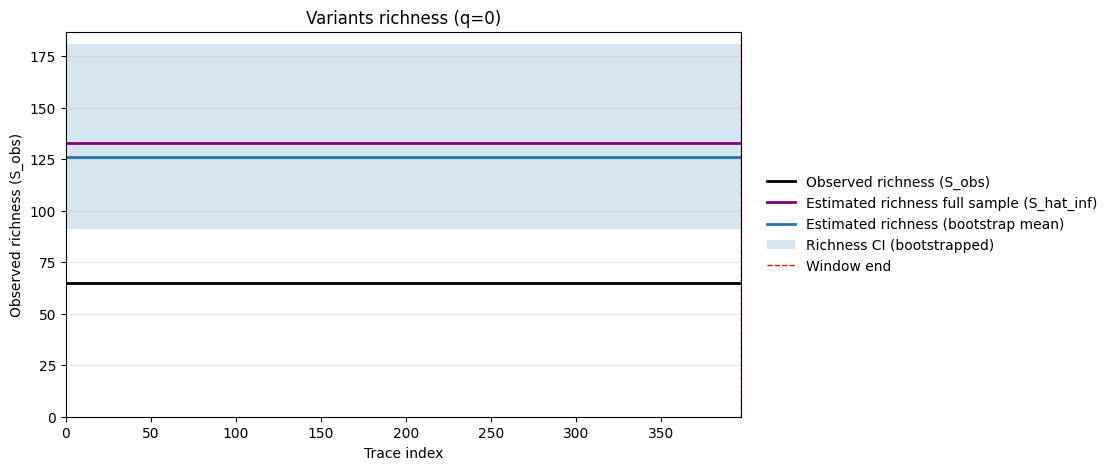

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:07<00:00, 1841.41it/s]


BPIC12


,window_id,window_start,window_end,S_obs,f1_or_Q1,f2_or_Q2,Estimator,S_hat_inf,CI_low,CI_high,Predicted_actual_boot_mean,C0_completeness,C1_coverage,alpha,bootstrap_mode,sample_size_n
0,W1,0,277,160,145,9,Chao1,1328.055556,646.431980,1528.733185,986.711972,0.120477,0.478651,0.05,population,278
1,W2,278,646,209,192,11,Chao1,1884.636364,927.509448,1998.387132,1352.387273,0.110897,0.479837,0.05,population,369
2,W3,647,855,115,102,8,Chao1,765.250000,391.040341,1056.177983,610.799044,0.150278,0.512329,0.05,population,209
3,W4,856,1463,292,264,17,Chao1,2341.882353,1226.964357,2155.729067,1601.661194,0.124686,0.565882,0.05,population,608
4,W5,1464,1813,180,165,5,Chao1,2902.500000,904.109339,2123.283997,1335.436957,0.062016,0.528653,0.05,population,350
5,W6,1814,1963,90,81,4,Chao1,910.125000,347.928846,1305.125000,646.176500,0.098888,0.460358,0.05,population,150
6,W7,1964,2623,337,303,17,Chao1,3037.264706,1499.910948,2552.112500,1949.665840,0.110955,0.540987,0.05,population,660
7,W8,2624,2884,154,142,5,Chao1,2170.400000,770.920455,2057.798750,1231.685586,0.070955,0.456086,0.05,population,261
8,W9,2885,3234,179,160,8,Chao1,1779.000000,761.724863,1632.017157,1098.384155,0.100618,0.542988,0.05,population,350
9,W10,3235,3415,58,47,5,Chao1,278.900000,136.450000,375.094643,223.441609,0.207960,0.740638,0.05,population,181


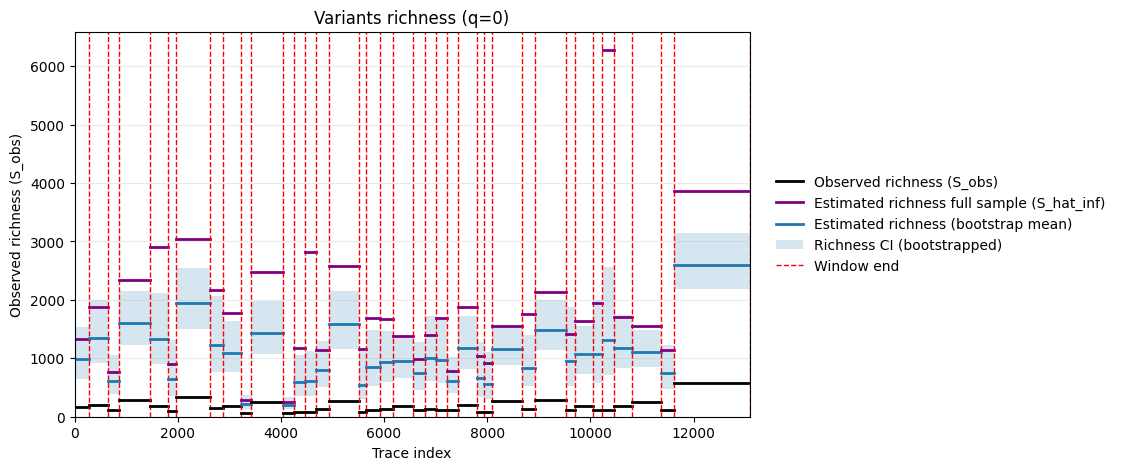

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2219.99it/s]


SEPSIS


,window_id,window_start,window_end,S_obs,f1_or_Q1,f2_or_Q2,Estimator,S_hat_inf,CI_low,CI_high,Predicted_actual_boot_mean,C0_completeness,C1_coverage,alpha,bootstrap_mode,sample_size_n
0,W1,0,1049,846,784,35,Chao1,9626.8,6222.819221,10233.19447,7873.00999,0.08788,0.253397,0.05,population,1050


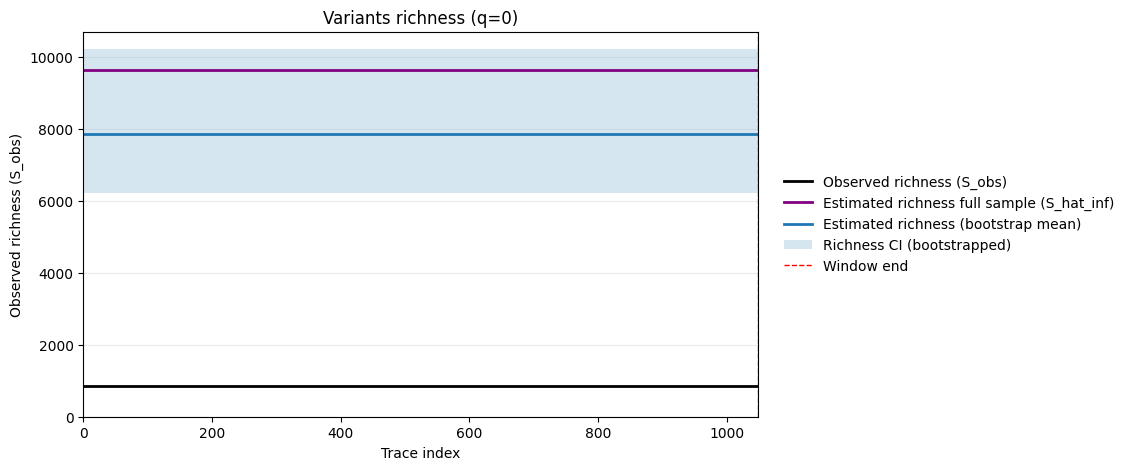

In [38]:
from pathlib import Path
from pm4py.objects.log.importer.xes import importer as xes_importer

configuration = "processGraphsPDefaultWDefault"

for dataset, dataset_info in data_dictionary.items():
    log_path = Path(dataset_info["path"])
    pm4py_log = xes_importer.apply(str(log_path))
    change_points = list(
        dd_results_df[
            (dd_results_df['configuration'] == configuration) &
            (dd_results_df['dataset'] == dataset)
        ]['change_point']
    )

    result_df = compute_richness_table_with_counter(
        pm4py_log, change_points,
        species_counter_fn=species_counter_variants,
        model="abundance",
        B=1000, alpha=0.05, seed=123,
        bootstrap_mode="population",   # "empirical"/ "population"
        enforce_bounds=False,
    )
    ax = plot_richness_result_df(result_df, title="Variants richness (q=0)")
    print(dataset)
    display(result_df)
    plt.show()

parsing log, completed traces :: 100%|██████████| 398/398 [00:00<00:00, 3820.05it/s]


ACCRE


,window_id,window_start,window_end,S_obs,f1_or_Q1,f2_or_Q2,Estimator,S_hat_inf,CI_low,CI_high,Predicted_actual_boot_mean,C0_completeness,C1_coverage,alpha,bootstrap_mode,sample_size_n
0,W1,0,397,77,25,7,Chao1,121.642857,58.718056,117.651786,79.575881,0.633001,0.983762,0.05,empirical,1539


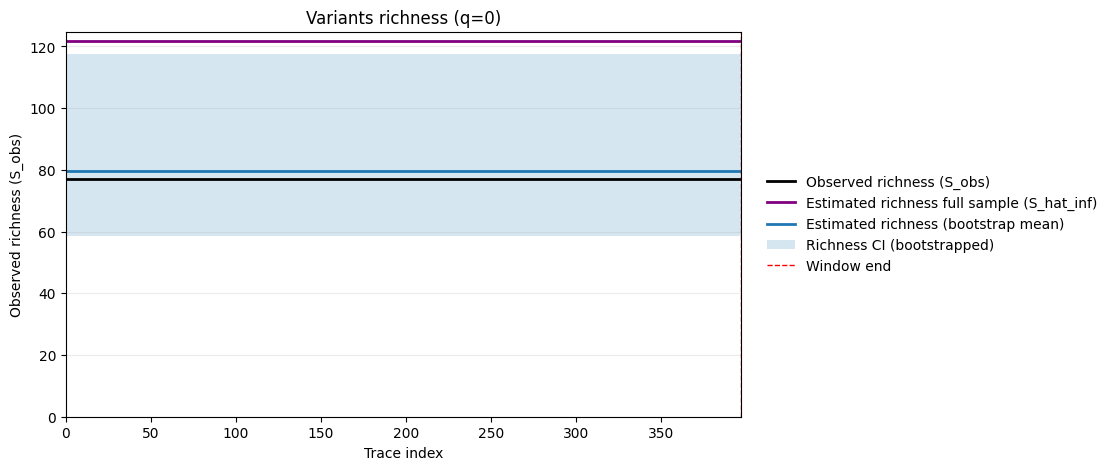

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:04<00:00, 2835.77it/s]


BPIC12


,window_id,window_start,window_end,S_obs,f1_or_Q1,f2_or_Q2,Estimator,S_hat_inf,CI_low,CI_high,Predicted_actual_boot_mean,C0_completeness,C1_coverage,alpha,bootstrap_mode,sample_size_n
0,W1,0,277,98,12,6,Chao1,110.000000,88.081250,126.675000,100.394404,0.890909,0.996533,0.05,empirical,3460
1,W2,278,646,97,6,9,Chao1,99.000000,90.000000,131.512500,99.894805,0.979798,0.998697,0.05,empirical,4601
2,W3,647,855,95,15,8,Chao1,109.062500,83.997500,132.310417,97.710735,0.871060,0.993900,0.05,empirical,2458
3,W4,856,1463,104,14,4,Chao1,128.500000,94.639286,149.025000,107.989388,0.809339,0.998015,0.05,empirical,7052
4,W5,1464,1813,103,15,8,Chao1,117.062500,91.666071,146.187500,107.008508,0.879872,0.996410,0.05,empirical,4177
5,W6,1814,1963,91,16,7,Chao1,109.285714,80.000000,139.550000,94.748477,0.832680,0.991683,0.05,empirical,1923
6,W7,1964,2623,107,11,7,Chao1,115.642857,98.071205,140.012500,109.648717,0.925263,0.998616,0.05,empirical,7948
7,W8,2624,2884,102,18,10,Chao1,118.200000,89.332143,141.187500,105.106696,0.862944,0.994560,0.05,empirical,3308
8,W9,2885,3234,99,6,13,Chao1,100.384615,90.597500,131.675000,101.954125,0.986207,0.998560,0.05,empirical,4162
9,W10,3235,3415,85,13,11,Chao1,92.681818,72.374279,130.006250,88.693453,0.917116,0.990699,0.05,empirical,1396


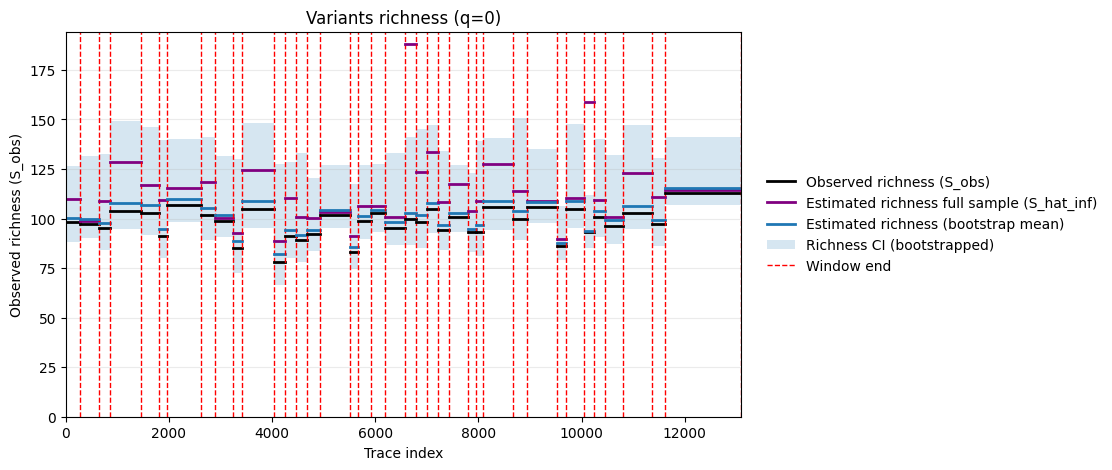

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2394.76it/s]


SEPSIS


,window_id,window_start,window_end,S_obs,f1_or_Q1,f2_or_Q2,Estimator,S_hat_inf,CI_low,CI_high,Predicted_actual_boot_mean,C0_completeness,C1_coverage,alpha,bootstrap_mode,sample_size_n
0,W1,0,1049,115,17,4,Chao1,151.125,105.599286,146.5,116.911177,0.760959,0.998483,0.05,empirical,11206


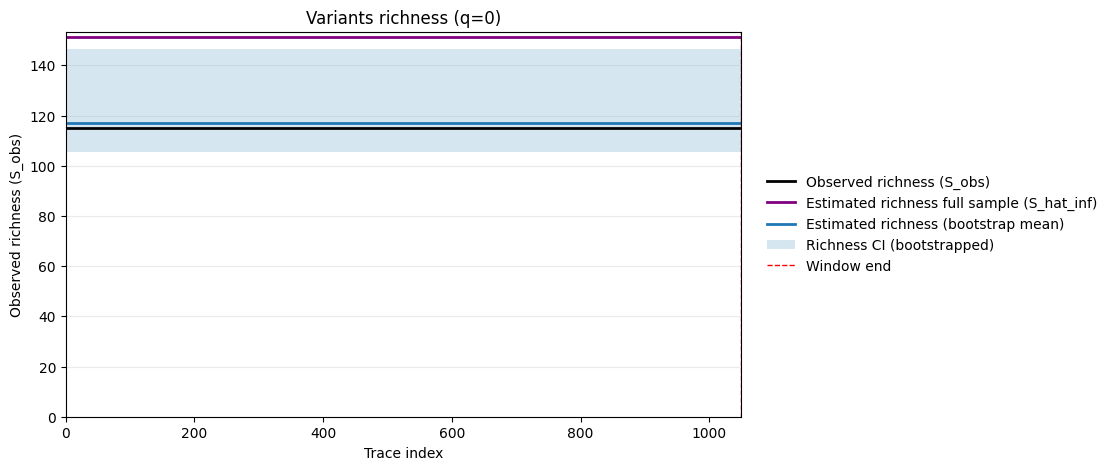

In [37]:
for dataset, dataset_info in data_dictionary.items():
    log_path = Path(dataset_info["path"])
    pm4py_log = xes_importer.apply(str(log_path))
    change_points = list(
        dd_results_df[
            (dd_results_df['configuration'] == configuration) &
            (dd_results_df['dataset'] == dataset)
        ]['change_point']
    )

    result_df = compute_richness_table_with_counter(
        pm4py_log, change_points,
        species_counter_fn=species_counter_df_edges,
        model="abundance",
        B=1000, alpha=0.05, seed=123,
        bootstrap_mode="population",   # "empirical"/ "population"
        enforce_bounds=False,
    )
    ax = plot_richness_result_df(result_df, title="Variants richness (q=0)")
    print(dataset)
    display(result_df)
    plt.show()

In [50]:
from __future__ import annotations
from typing import List, Dict, Any, Tuple, Optional, Callable
import numpy as np
import pandas as pd
import math

# ============================================================
# Utility: stable combinatorics
# ============================================================
def _logchoose(n: int, k: int) -> float:
    if k < 0 or k > n:
        return float("-inf")
    return math.lgamma(n + 1) - math.lgamma(k + 1) - math.lgamma(n - k + 1)

def _ratio_choose(n1: int, k1: int, n2: int, k2: int) -> float:
    return math.exp(_logchoose(n1, k1) - _logchoose(n2, k2))

# ============================================================
# Split by change points
# ============================================================
def split_log_by_change_points(pm4py_log, change_points: List[int]):
    n = len(pm4py_log)
    cps = sorted(set(int(cp) for cp in change_points if 0 < cp < n))
    bounds = [0] + cps + [n]
    chunks = []
    for i in range(len(bounds) - 1):
        start, end = bounds[i], bounds[i + 1]
        if end > start:
            chunks.append(pm4py_log[start:end])
    return chunks, bounds

# ============================================================
# Species counters (examples; swap with your own)
# ============================================================
def species_counter_variants(chunk) -> Tuple[Dict[Any, int], Dict[str, int]]:
    """Abundance model (Chao1). One species per trace = its activity-sequence variant."""
    counts: Dict[Any, int] = {}
    for trace in chunk:
        variant = tuple(ev["concept:name"] for ev in trace)
        counts[variant] = counts.get(variant, 0) + 1
    meta = {"n": sum(counts.values())}
    return counts, meta

def species_counter_df_edges(chunk) -> Tuple[Dict[Any, int], Dict[str, int]]:
    """Incidence model (Chao2). Species are directly-follows edges; presence per trace."""
    counts: Dict[Any, int] = {}
    for trace in chunk:
        acts = [ev["concept:name"] for ev in trace]
        present = set((acts[i], acts[i+1]) for i in range(len(acts) - 1))
        for sp in present:
            counts[sp] = counts.get(sp, 0) + 1
    meta = {"T": len(chunk), "U": sum(counts.values())}
    return counts, meta

# ============================================================
# q = 0 (abundance, Chao1) — core pieces
# ============================================================
def _abund_basic_counts(counts: Dict[Any,int]) -> Tuple[int,int,int,int]:
    xs = list(counts.values())
    n = int(sum(xs))
    S_obs = len(xs)
    f1 = sum(1 for c in xs if c == 1)
    f2 = sum(1 for c in xs if c == 2)
    return S_obs, n, f1, f2

def _abund_cov_ref(n: int, f1: int, f2: int) -> float:
    denom = (n - 1) * f1 + 2 * f2
    adj = ((n - 1) * f1 / denom) if denom > 0 else 1.0
    return 1.0 - (f1 / n) * adj

def _abund_rarefied_S(counts: Dict[Any,int], m: int, n: int) -> float:
    S_obs = len(counts)
    if m <= 0:
        return 0.0
    term = 0.0
    for Xi in counts.values():
        if n - Xi >= m:
            term += _ratio_choose(n - Xi, m, n, m)
    return S_obs - term

def _abund_rarefied_C(counts: Dict[Any,int], m: int, n: int) -> float:
    if m < 0 or m > n - 1:
        raise ValueError("m must satisfy 0 <= m < n for abundance rarefaction coverage.")
    denom_log = _logchoose(n - 1, m)
    s = 0.0
    for Xi in counts.values():
        if n - Xi >= m:
            num_log = _logchoose(n - Xi, m)
            s += (Xi / n) * math.exp(num_log - denom_log)
    return 1.0 - s

def _abund_f0_hat(n: int, f1: int, f2: int) -> float:
    if f2 > 0:
        return ((n - 1) / n) * (f1 * f1) / (2.0 * f2)
    return ((n - 1) / n) * (f1 * (f1 - 1)) / (2.0 * (f2 + 1))

def _abund_extrapolated_S(n: int, S_obs: int, f1: int, f0_hat: float, mstar: int) -> float:
    if mstar <= 0:
        return float(S_obs)
    denom = n * f0_hat + f1
    if denom <= 0:
        return float(S_obs)
    p = f1 / denom
    return S_obs + f0_hat * (1.0 - (1.0 - p) ** mstar)

def _abund_extrapolated_C(n: int, f1: int, f2: int, mstar: int) -> float:
    denom = (n - 1) * f1 + 2 * f2
    a = ((n - 1) * f1 / denom) if denom > 0 else 1.0
    return 1.0 - (f1 / n) * (a ** (mstar + 1))

# Find richness at target coverage and the effort that achieves it
def _abund_richness_and_effort_at_coverage(
    counts: Dict[Any,int],
    coverage_target: float,
    max_extrap_multiplier: float = 2.0
) -> Tuple[float, str, int, int, float, float]:
    """
    Returns:
      (S_at_target, mode, effort_low, effort_high, weight, Cmax)
    mode ∈ {"rarefy", "extrap"}.
    If mode == "rarefy": efforts are m_low, m_high (integers with m_high = m_low+1),
      and S_at_target = (1-w)*S(m_low) + w*S(m_high) using rarefaction formulas.
    If mode == "extrap": efforts are t_low, t_high (integers with t_high = t_low+1),
      and S_at_target = (1-w)*S(t_low) + w*S(t_high) using extrapolation formulas.
    """
    S_obs, n, f1, f2 = _abund_basic_counts(counts)
    Cn = _abund_cov_ref(n, f1, f2)

    mstar_max = int(math.floor((max_extrap_multiplier - 1.0) * n))
    Cmax = _abund_extrapolated_C(n, f1, f2, mstar_max)
    g = min(coverage_target, Cmax)

    if g <= Cn:
        # --- rarefaction side: find smallest m with C(m) >= g
        lo, hi = 1, max(1, n - 1)
        while lo < hi:
            mid = (lo + hi) // 2
            Cm = _abund_rarefied_C(counts, mid, n)
            if Cm < g:
                lo = mid + 1
            else:
                hi = mid
        m_high = min(lo, n - 1)
        m_low  = max(1, m_high - 1)

        C_low  = _abund_rarefied_C(counts, m_low,  n)
        C_high = _abund_rarefied_C(counts, m_high, n)
        S_low  = _abund_rarefied_S(counts, m_low,  n)
        S_high = _abund_rarefied_S(counts, m_high, n)

        w = 0.0 if C_high == C_low else (g - C_low) / (C_high - C_low)
        Sg = (1.0 - w) * S_low + w * S_high
        return float(Sg), "rarefy", int(m_low), int(m_high), float(w), float(Cmax)

    # --- extrapolation side: find smallest t with C(n+t) >= g
    denom = (n - 1) * f1 + 2 * f2
    a = ((n - 1) * f1 / denom) if denom > 0 else 1.0
    if a <= 0 or a >= 1:
        t_high = 0
    else:
        rhs = (1.0 - g) / (f1 / n)
        rhs = max(rhs, 1e-16)
        t_high = max(0, int(math.ceil(math.log(rhs) / math.log(a)) - 1))
    t_high = min(t_high, mstar_max)
    t_low  = max(0, t_high - 1)

    C_low  = _abund_extrapolated_C(n, f1, f2, t_low)
    C_high = _abund_extrapolated_C(n, f1, f2, t_high)

    f0_hat = _abund_f0_hat(n, f1, f2)
    S_low  = _abund_extrapolated_S(n, S_obs, f1, f0_hat, t_low)
    S_high = _abund_extrapolated_S(n, S_obs, f1, f0_hat, t_high)

    w = 0.0 if C_high == C_low else (g - C_low) / (C_high - C_low)
    Sg = (1.0 - w) * S_low + w * S_high
    return float(Sg), "extrap", int(t_low), int(t_high), float(w), float(Cmax)


# Chao1 richness and coverage for the full sample (for ^0D(∞), ^0C, ^1C)
def chao1_full(counts: Dict[Any,int]) -> Dict[str, float]:
    S_obs, n, f1, f2 = _abund_basic_counts(counts)
    S_hat = S_obs + (f1 * f1) / (2.0 * f2) if f2 > 0 else S_obs + (f1 * (f1 - 1)) / 2.0
    C0 = S_obs / S_hat if S_hat > 0 else float("nan")
    C1 = _abund_cov_ref(n, f1, f2) if n > 0 else float("nan")
    return {"S_obs": float(S_obs), "^0D_infty": float(S_hat), "^0C": float(C0), "^1C": float(C1), "n": float(n)}

# q=1,2 (abundance) — practical population estimators
def hill_q1_abundance(counts: Dict[Any,int]) -> float:
    """Miller–Madow bias-corrected Shannon -> ^1D = exp(H_MM)."""
    xs = np.array(list(counts.values()), dtype=float)
    n = xs.sum()
    if n <= 0:
        return float("nan")
    p = xs / n
    p = p[p > 0]
    H_mle = -float(np.sum(p * np.log(p)))
    S_obs = len(p)
    H_mm = H_mle + (S_obs - 1) / (2.0 * n)  # Miller–Madow
    return float(np.exp(H_mm))

def hill_q2_abundance(counts: Dict[Any,int]) -> float:
    """Unbiased Simpson lambda -> ^2D = 1 / lambda_hat."""
    xs = np.array(list(counts.values()), dtype=float)
    n = xs.sum()
    if n <= 1:
        return float("nan")
    lam = float(np.sum(xs * (xs - 1.0)) / (n * (n - 1.0)))  # unbiased for Σ p_i^2
    return float(1.0 / lam) if lam > 0 else float("inf")

# ============================================================
# q = 0 (incidence, Chao2) — core pieces
# ============================================================
def _incid_basic_counts(counts: Dict[Any,int], T: int, U: int) -> Tuple[int,int,int]:
    ys = list(counts.values())
    S_obs = len(ys)
    freq: Dict[int,int] = {}
    for y in ys:
        freq[y] = freq.get(y, 0) + 1
    Q1 = freq.get(1, 0)
    Q2 = freq.get(2, 0)
    return S_obs, Q1, Q2

def _incid_cov_ref(T: int, U: int, Q1: int, Q2: int) -> float:
    denom = (T - 1) * Q1 + 2 * Q2
    adj = ((T - 1) * Q1 / denom) if denom > 0 else 1.0
    return 1.0 - (Q1 / U) * adj if U > 0 else float("nan")

def _incid_rarefied_S(counts: Dict[Any,int], m: int, T: int) -> float:
    S_obs = len(counts)
    if m <= 0:
        return 0.0
    term = 0.0
    for Yi in counts.values():
        if T - Yi >= m:
            term += _ratio_choose(T - Yi, m, T, m)
    return S_obs - term

def _incid_rarefied_C(counts: Dict[Any,int], m: int, T: int, U: int) -> float:
    denom_log = _logchoose(T - 1, m)
    s = 0.0
    for Yi in counts.values():
        if T - Yi >= m:
            num_log = _logchoose(T - Yi, m)
            s += (Yi / U) * math.exp(num_log - denom_log)
    return 1.0 - s

def _incid_Q0_hat(T: int, Q1: int, Q2: int) -> float:
    if Q2 > 0:
        return ((T - 1) / T) * (Q1 * Q1) / (2.0 * Q2)
    return ((T - 1) / T) * (Q1 * (Q1 - 1)) / (2.0 * (Q2 + 1))

def _incid_extrapolated_S(T: int, S_obs: int, Q1: int, Q0_hat: float, t: int) -> float:
    if t <= 0:
        return float(S_obs)
    denom = T * Q0_hat + Q1
    if denom <= 0:
        return float(S_obs)
    p = Q1 / denom
    return S_obs + Q0_hat * (1.0 - (1.0 - p) ** t)

def _incid_extrapolated_C(T: int, U: int, Q1: int, Q2: int, t: int) -> float:
    denom = (T - 1) * Q1 + 2 * Q2
    a = ((T - 1) * Q1 / denom) if denom > 0 else 1.0
    return 1.0 - (Q1 / U) * (a ** (t + 1)) if U > 0 else float("nan")

def _incid_richness_and_effort_at_coverage(
    counts: Dict[Any,int], T: int, U: int,
    coverage_target: float,
    max_extrap_multiplier: float = 2.0
) -> Tuple[float, str, int, int, float, float]:
    """
    Returns:
      (S_at_target, mode, effort_low, effort_high, weight, Cmax)
    Efforts are m_low/m_high (rarefy) or t_low/t_high (extrap).
    """
    S_obs, Q1, Q2 = _incid_basic_counts(counts, T, U)
    C_T = _incid_cov_ref(T, U, Q1, Q2)

    t_max = int(math.floor((max_extrap_multiplier - 1.0) * T))
    Cmax = _incid_extrapolated_C(T, U, Q1, Q2, t_max)
    g = min(coverage_target, Cmax)

    if g <= C_T:
        lo, hi = 1, max(1, T - 1)
        while lo < hi:
            mid = (lo + hi) // 2
            Cm = _incid_rarefied_C(counts, mid, T, U)
            if Cm < g:
                lo = mid + 1
            else:
                hi = mid
        m_high = min(lo, T - 1)
        m_low  = max(1, m_high - 1)

        C_low  = _incid_rarefied_C(counts, m_low,  T, U)
        C_high = _incid_rarefied_C(counts, m_high, T, U)
        S_low  = _incid_rarefied_S(counts, m_low,  T)
        S_high = _incid_rarefied_S(counts, m_high, T)

        w = 0.0 if C_high == C_low else (g - C_low) / (C_high - C_low)
        Sg = (1.0 - w) * S_low + w * S_high
        return float(Sg), "rarefy", int(m_low), int(m_high), float(w), float(Cmax)

    denom = (T - 1) * Q1 + 2 * Q2
    a = ((T - 1) * Q1 / denom) if denom > 0 else 1.0
    if a <= 0 or a >= 1 or U == 0:
        t_high = 0
    else:
        rhs = (1.0 - g) / (Q1 / U)
        rhs = max(rhs, 1e-16)
        t_high = max(0, int(math.ceil(math.log(rhs) / math.log(a)) - 1))
    t_high = min(t_high, t_max)
    t_low  = max(0, t_high - 1)

    C_low  = _incid_extrapolated_C(T, U, Q1, Q2, t_low)
    C_high = _incid_extrapolated_C(T, U, Q1, Q2, t_high)

    Q0_hat = _incid_Q0_hat(T, Q1, Q2)
    S_low  = _incid_extrapolated_S(T, S_obs, Q1, Q0_hat, t_low)
    S_high = _incid_extrapolated_S(T, S_obs, Q1, Q0_hat, t_high)

    w = 0.0 if C_high == C_low else (g - C_low) / (C_high - C_low)
    Sg = (1.0 - w) * S_low + w * S_high
    return float(Sg), "extrap", int(t_low), int(t_high), float(w), float(Cmax)


# Chao2 richness & coverage for the full sample (for ^0D(∞), ^0C, ^1C)
def chao2_full(counts: Dict[Any,int], T: int, U: int) -> Dict[str, float]:
    S_obs, Q1, Q2 = _incid_basic_counts(counts, T, U)
    S_hat = S_obs + ((T - 1) / T) * (Q1 * Q1) / (2.0 * Q2) if Q2 > 0 else S_obs + (Q1 * (Q1 - 1)) / 2.0
    C0 = S_obs / S_hat if S_hat > 0 else float("nan")
    C1 = _incid_cov_ref(T, U, Q1, Q2)
    return {"S_obs": float(S_obs), "^0D_infty": float(S_hat), "^0C": float(C0), "^1C": float(C1), "T": float(T), "U": float(U)}

# q=1,2 (incidence) — practical population approximations via incidence proportions
def hill_q1_incidence(counts: Dict[Any,int], U: int) -> float:
    if U <= 0:
        return float("nan")
    p = np.array(list(counts.values()), dtype=float) / float(U)
    p = p[p > 0]
    H = -float(np.sum(p * np.log(p)))
    return float(np.exp(H))

def hill_q2_incidence(counts: Dict[Any,int], U: int) -> float:
    if U <= 0:
        return float("nan")
    p2 = np.sum((np.array(list(counts.values()), dtype=float) / float(U)) ** 2)
    return float(1.0 / p2) if p2 > 0 else float("inf")

# ============================================================
# Equal-coverage table with FIXED-EFFORT bootstrap (faithful)
# ============================================================
def compute_equal_coverage_table(
    pm4py_log,
    change_points: List[int],
    species_counter_fn: Callable[[list], Tuple[Dict[Any, int], Dict[str, int]]],
    model: str = "abundance",
    target_coverage: Optional[float] = None,
    max_extrap_multiplier: float = 2.0,
    B: int = 200,
    alpha: float = 0.05,
    seed: Optional[int] = 42,
    log_label: str = "",
    species_label: str = "",
) -> pd.DataFrame:

    chunks, bounds = split_log_by_change_points(pm4py_log, change_points)

    # pass 1: compute each window’s Cmax (≤ 2x) and base columns
    max_coverages, base_meta = [], []
    for chunk in chunks:
        counts, meta = species_counter_fn(chunk)
        if model == "abundance":
            d0 = chao1_full(counts)
            d1 = hill_q1_abundance(counts)
            d2 = hill_q2_abundance(counts)
            S_obs, n, f1, f2 = _abund_basic_counts(counts)
            Cmax = _abund_extrapolated_C(n, f1, f2, int((max_extrap_multiplier - 1.0) * n))
        else:
            T = meta.get("T", len(chunk))
            U = meta.get("U", sum(counts.values()))
            d0 = chao2_full(counts, T, U)
            d1 = hill_q1_incidence(counts, U)
            d2 = hill_q2_incidence(counts, U)
            S_obs, Q1, Q2 = _incid_basic_counts(counts, T, U)
            Cmax = _incid_extrapolated_C(T, U, Q1, Q2, int((max_extrap_multiplier - 1.0) * T))
        base_meta.append({**d0, "^1D_infty": d1, "^2D_infty": d2})
        max_coverages.append(Cmax)

    # choose base coverage g*
    if target_coverage is None:
        g_star = min(c for c in max_coverages if np.isfinite(c))
    else:
        g_star = min(float(target_coverage), min(c for c in max_coverages if np.isfinite(c)))

    rng = np.random.default_rng(seed)
    rows = []

    for i, chunk in enumerate(chunks):
        window_id = f"W{i+1}"
        window_start, window_end = bounds[i], bounds[i+1] - 1
        traces = list(chunk)
        counts, meta = species_counter_fn(traces)

        if model == "abundance":
            Sg, mode, e_low, e_high, w, Cmax = _abund_richness_and_effort_at_coverage(
                counts, g_star, max_extrap_multiplier
            )
        else:
            T = meta.get("T", len(traces))
            U = meta.get("U", sum(counts.values()))
            Sg, mode, e_low, e_high, w, Cmax = _incid_richness_and_effort_at_coverage(
                counts, T, U, g_star, max_extrap_multiplier
            )

        # ----- FIXED-EFFORT, SAME-INTERPOLATION BOOTSTRAP -----
        m = len(traces)
        boots = np.empty(B, dtype=float)
        for b in range(B):
            idx = rng.integers(0, m, size=m)
            resample = [traces[j] for j in idx]
            c_b, meta_b = species_counter_fn(resample)

            if model == "abundance":
                S_obs_b, n_b, f1_b, f2_b = _abund_basic_counts(c_b)
                if mode == "rarefy":
                    # compute both rarefaction points, then mix with SAME weight w
                    m1 = min(max(e_low,  1), n_b - 1) if n_b > 1 else 0
                    m2 = min(max(e_high, 1), n_b - 1) if n_b > 1 else 0
                    S1 = _abund_rarefied_S(c_b, m1, n_b) if m1 > 0 else float(S_obs_b)
                    S2 = _abund_rarefied_S(c_b, m2, n_b) if m2 > 0 else float(S_obs_b)
                    S_b = (1.0 - w) * S1 + w * S2
                else:
                    f0_b = _abund_f0_hat(n_b, f1_b, f2_b)
                    t1 = max(e_low,  0)
                    t2 = max(e_high, 0)
                    S1 = _abund_extrapolated_S(n_b, S_obs_b, f1_b, f0_b, t1)
                    S2 = _abund_extrapolated_S(n_b, S_obs_b, f1_b, f0_b, t2)
                    S_b = (1.0 - w) * S1 + w * S2
            else:
                T_b = meta_b.get("T", len(resample))
                U_b = meta_b.get("U", sum(c_b.values()))
                S_obs_b, Q1_b, Q2_b = _incid_basic_counts(c_b, T_b, U_b)
                if mode == "rarefy":
                    m1 = min(max(e_low,  1), T_b - 1) if T_b > 1 else 0
                    m2 = min(max(e_high, 1), T_b - 1) if T_b > 1 else 0
                    S1 = _incid_rarefied_S(c_b, m1, T_b) if m1 > 0 else float(S_obs_b)
                    S2 = _incid_rarefied_S(c_b, m2, T_b) if m2 > 0 else float(S_obs_b)
                    S_b = (1.0 - w) * S1 + w * S2
                else:
                    Q0_b = _incid_Q0_hat(T_b, Q1_b, Q2_b)
                    t1 = max(e_low,  0)
                    t2 = max(e_high, 0)
                    S1 = _incid_extrapolated_S(T_b, S_obs_b, Q1_b, Q0_b, t1)
                    S2 = _incid_extrapolated_S(T_b, S_obs_b, Q1_b, Q0_b, t2)
                    S_b = (1.0 - w) * S1 + w * S2

            boots[b] = S_b

        lo = float(np.percentile(boots, 100 * (alpha / 2.0)))
        hi = float(np.percentile(boots, 100 * (1 - alpha / 2.0)))
        mean = float(np.mean(boots))

        base = base_meta[i]
        rows.append({
            "Log": log_label,
            "Species_Def": species_label,
            "window_id": window_id,
            "window_start": window_start,
            "window_end": window_end,
            "model": model,
            "S_obs": int(base["S_obs"]),
            "^0D_infty": float(base["^0D_infty"]),
            "^1D_infty": float(base["^1D_infty"]),
            "^2D_infty": float(base["^2D_infty"]),
            "^0C": float(base["^0C"]),
            "^1C": float(base["^1C"]),
            "target_coverage": float(g_star),
            "effort_mode": mode,                # "rarefy" or "extrap"
            "effort_low": int(e_low),
            "effort_high": int(e_high),
            "interp_weight": float(w),
            "S_at_target": float(Sg),
            "CI_low": lo,
            "CI_high": hi,
            "boot_mean": mean,
            "C_max_2x": float(Cmax),
            "alpha": float(alpha),
            "B": int(B),
        })

    cols = [
        "Log","Species_Def","window_id","window_start","window_end","model",
        "S_obs","^0D_infty","^1D_infty","^2D_infty","^0C","^1C",
        "target_coverage","effort_mode","effort_low","effort_high","interp_weight",
        "S_at_target","CI_low","CI_high","boot_mean","C_max_2x","alpha","B"
    ]
    return pd.DataFrame(rows, columns=cols)



In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_equal_coverage_result_df(
    result_df: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
    title: Optional[str] = None,
    y_label: str = "Richness at target coverage",
    show_observed: bool = True,        # draw S_obs as black baseline per window
    show_boot_mean: bool = True,       # draw bootstrap mean line per window
):
    """
    Expects the DataFrame from compute_equal_coverage_table with columns:
      ["window_start","window_end","S_obs","S_at_target","CI_low","CI_high","boot_mean","target_coverage"]
    Draws:
      - S_obs (optional) in black (piecewise constant per window)
      - S_at_target in blue (point estimate at the common coverage)
      - CI band [CI_low, CI_high] in light blue
      - red dotted vertical line at each window end
      - legend placed to the RIGHT (outside the axes)
    """
    required = {"window_start", "window_end", "S_obs", "S_at_target", "CI_low", "CI_high", "boot_mean", "target_coverage"}
    missing = required - set(result_df.columns)
    if missing:
        raise ValueError(f"result_df missing columns: {sorted(missing)}")

    df = result_df.sort_values("window_start").reset_index(drop=True)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_fig = True
    else:
        fig = ax.figure

    # one global target coverage (the function uses a common target)
    g_star = float(df["target_coverage"].iloc[0])

    for _, row in df.iterrows():
        x0, x1 = int(row["window_start"]), int(row["window_end"])
        y_obs = float(row["S_obs"])
        y_at_target = float(row["S_at_target"])
        y_boot = float(row["boot_mean"])
        lo, hi = float(row["CI_low"]), float(row["CI_high"])

        # CI band at target coverage (per window span)
        ax.fill_between([x0, x1], [lo, lo], [hi, hi],
                        alpha=0.18, step="pre", color="tab:blue", linewidth=0)

        # Observed richness at reference effort (optional)
        if show_observed:
            ax.plot([x0, x1], [y_obs, y_obs], color="black", linewidth=2, label="_nolegend_")

        # Point estimate at target coverage
        ax.plot([x0, x1], [y_at_target, y_at_target], color="tab:blue", linewidth=2, label="_nolegend_")

        # Bootstrap mean at target coverage (optional)
        if show_boot_mean:
            ax.plot([x0, x1], [y_boot, y_boot], color="tab:blue", linewidth=2, linestyle="--", label="_nolegend_")

        # Window end marker
        ax.axvline(x=x1, linestyle="--", color="red", linewidth=1)

    ax.set_xlabel("Trace index")
    ax.set_ylabel(y_label)
    if title is None:
        title = f"Equal-coverage richness (q=0) — target coverage g* = {g_star:.3f}"
    ax.set_title(title)

    ax.set_xlim(int(df["window_start"].min()), int(df["window_end"].max()))
    ax.set_ylim(bottom=0)
    ax.grid(True, axis="y", alpha=0.25)

    # Legend OUTSIDE on the right
    legend_elems = []
    if show_observed:
        legend_elems.append(Line2D([0], [0], color="black", lw=2, label="Observed richness (S_obs)"))
    legend_elems.extend([
        Line2D([0], [0], color="tab:blue", lw=2, label="Richness at target coverage (S_at_target)"),
    ])
    if show_boot_mean:
        legend_elems.append(Line2D([0], [0], color="tab:blue", lw=2, ls="--", label="Bootstrap mean (at target)"))
    legend_elems.extend([
        Patch(facecolor="tab:blue", alpha=0.18, label="95% CI at target coverage"),
        Line2D([0], [0], color="red", lw=1, ls="--", label="Window end"),
    ])

    ax.legend(handles=legend_elems, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    if created_fig:
        fig.subplots_adjust(right=0.8)  # space for legend

    return ax


ACCRE


parsing log, completed traces :: 100%|██████████| 398/398 [00:00<00:00, 6739.71it/s]


,Log,Species_Def,window_id,window_start,window_end,model,S_obs,^0D_infty,^1D_infty,^2D_infty,...,effort_low,effort_high,interp_weight,S_at_target,CI_low,CI_high,boot_mean,C_max_2x,alpha,B
0,mylog,s_var,W1,0,397,abundance,65,133.055556,16.905922,6.067819,...,397,398,1.0,92.333533,50.521673,70.688947,60.44672,0.947537,0.05,400


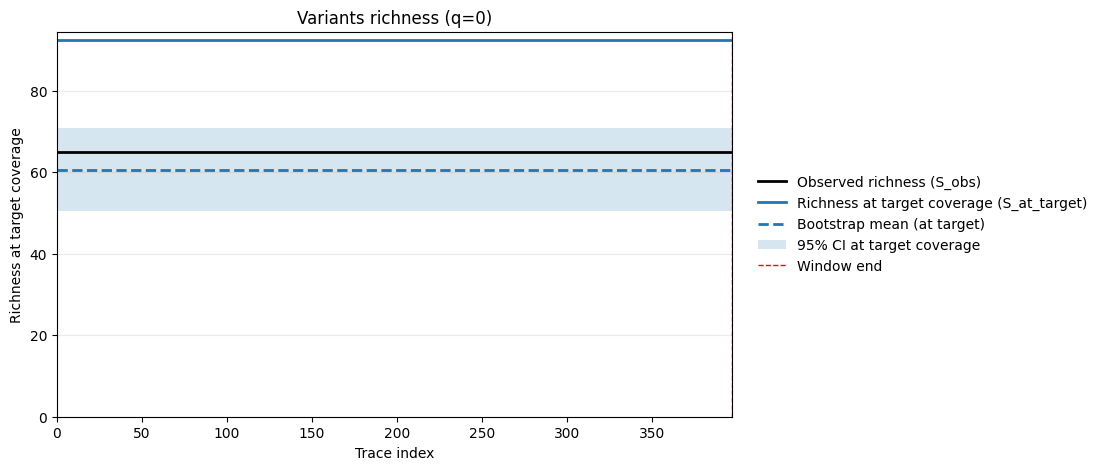

BPIC12


parsing log, completed traces :: 100%|██████████| 13087/13087 [00:06<00:00, 1986.92it/s]


,Log,Species_Def,window_id,window_start,window_end,model,S_obs,^0D_infty,^1D_infty,^2D_infty,...,effort_low,effort_high,interp_weight,S_at_target,CI_low,CI_high,boot_mean,C_max_2x,alpha,B
0,mylog,s_var,W1,0,277,abundance,160,1328.055556,80.230015,14.970062,...,172,173,0.708258,103.637125,72.817095,85.597199,79.301518,0.539708,0.05,400
1,mylog,s_var,W2,278,646,abundance,209,1884.636364,95.313201,15.347197,...,192,193,0.995420,114.849075,84.523257,96.822264,91.161481,0.536287,0.05,400
2,mylog,s_var,W3,647,855,abundance,115,765.250000,59.527905,13.670440,...,76,77,0.681550,46.717359,35.949271,43.617635,39.811665,0.583418,0.05,400
3,mylog,s_var,W4,856,1463,abundance,292,2341.882353,81.020106,10.631943,...,35,36,0.345327,21.993255,20.176915,22.667204,21.449411,0.618416,0.05,400
4,mylog,s_var,W5,1464,1813,abundance,180,2902.500000,67.051139,10.865504,...,51,52,0.040260,31.210751,27.189054,31.534121,29.213914,0.556446,0.05,400
5,mylog,s_var,W6,1814,1963,abundance,90,910.125000,58.103357,15.695225,...,123,124,0.986070,75.821844,47.574354,59.298456,53.611230,0.511416,0.05,400
6,mylog,s_var,W7,1964,2623,abundance,337,3037.264706,111.305956,13.742180,...,107,108,0.447046,64.848473,57.227764,63.428375,60.265374,0.589775,0.05,400
7,mylog,s_var,W8,2624,2884,abundance,154,2170.400000,79.855457,14.940555,...,222,223,0.385996,132.872053,84.070419,99.946358,92.262343,0.493205,0.05,400
8,mylog,s_var,W9,2885,3234,abundance,179,1779.000000,73.072347,12.684320,...,58,59,0.658568,36.276179,31.259419,36.230017,33.757585,0.586591,0.05,400
9,mylog,s_var,W10,3235,3415,abundance,58,278.900000,16.111835,5.376238,...,3,4,0.665258,2.892494,2.723295,3.003050,2.869234,0.790567,0.05,400


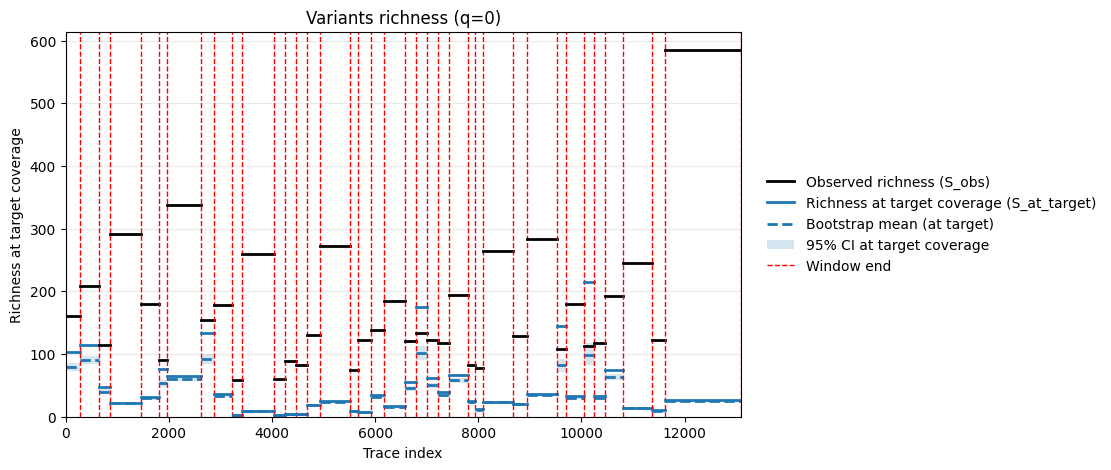

SEPSIS


parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 1842.41it/s]


,Log,Species_Def,window_id,window_start,window_end,model,S_obs,^0D_infty,^1D_infty,^2D_infty,...,effort_low,effort_high,interp_weight,S_at_target,CI_low,CI_high,boot_mean,C_max_2x,alpha,B
0,mylog,s_var,W1,0,1049,abundance,846,9626.8,965.109726,383.513231,...,1049,1050,1.0,1595.95687,694.732187,780.42668,737.935184,0.317224,0.05,400


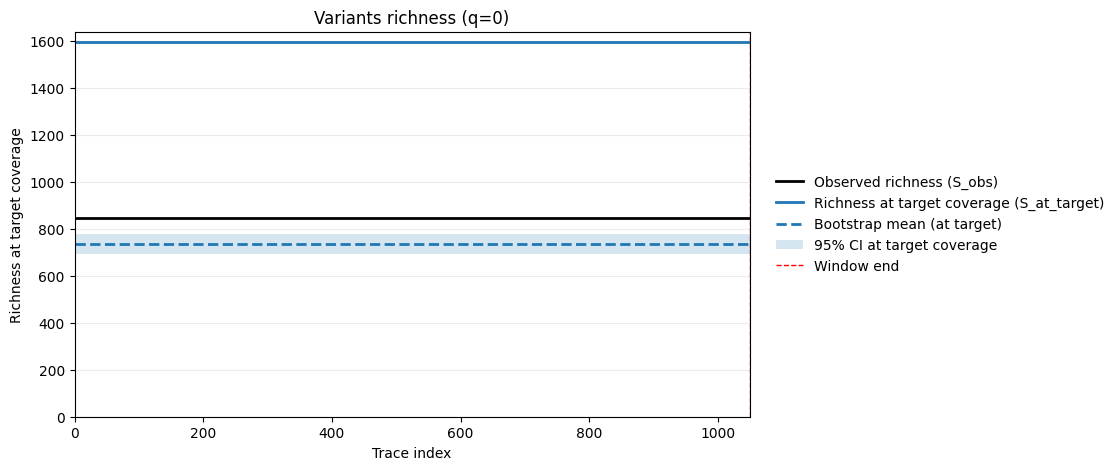

In [52]:
from pathlib import Path
from pm4py.objects.log.importer.xes import importer as xes_importer

configuration = "processGraphsPDefaultWDefault"

for dataset, dataset_info in data_dictionary.items():
    print(dataset)
    log_path = Path(dataset_info["path"])
    pm4py_log = xes_importer.apply(str(log_path))
    change_points = list(
        dd_results_df[
            (dd_results_df['configuration'] == configuration) &
            (dd_results_df['dataset'] == dataset)
        ]['change_point']
    )

    result_df = compute_equal_coverage_table(
        pm4py_log, change_points,
        species_counter_fn=species_counter_variants,
        model="abundance",
        target_coverage=None,         # auto-select base coverage across windows
        max_extrap_multiplier=2.0,
        B=400, alpha=0.05, seed=123,
        log_label="mylog", species_label="s_var"
    )
    display(result_df)
    ax = plot_equal_coverage_result_df(result_df, title="Variants richness (q=0)")
    plt.show()